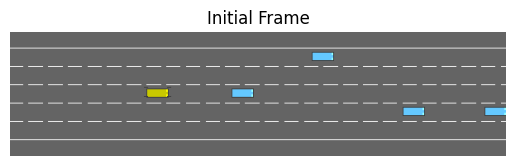

In [1]:
# Import libraries and make sure highway-env is installed properly
import gymnasium
import highway_env
import numpy as np
import matplotlib.pyplot as plt

# Create the environment with visual rendering
env = gymnasium.make("highway-better-v1", render_mode="rgb_array")
obs, info = env.reset()

# Render and show the first frame
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title("Initial Frame")
plt.show()

env.close()

In [2]:
from pprint import pprint
# print the environment information
print("Environment Information:")
pprint(env.unwrapped.config)

import tensorboard
print(tensorboard.__version__)

Environment Information:
{'action': {'acceleration_range': [-1, 1],
            'lateral': True,
            'longitudinal': True,
            'speed_range': [0, 40],
            'steering_range': [-0.1, 0.1],
            'type': 'ContinuousAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 60,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 5,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'absolute': False,
                 'features': ['presence',
                              'x',
                              'y',
                              'vx',
                              'vy',
                              'heading',
                              'lat_off'],
                 'type': 'Kinematics',
                 'vehicles_count': 40},
 'offroad_terminal': True,
 'offscreen_rendering': False,
 'on_road_reward': 0.5,
 'other_v

In [3]:
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor

# === Create wrapped evaluation env ===
def make_env(str_env=None):
    def _init():
        if str_env is None or str_env == "highway":
            env_id = "highway-better-v1"
        elif str_env == "intersection":
            env_id = "intersection-v1"
        elif str_env == "intersection_discrete":
            env_id = "intersection-v0"
        elif str_env == "racetrack":
            env_id = "racetrack-v0"
        else:
            raise ValueError(f"Unknown environment: {str_env}")

        env = gym.make(env_id, render_mode="rgb_array")
        return Monitor(env)
    return _init


In [4]:
import optuna
import torch
import os
import json
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from optuna.pruners import MedianPruner

# === Global reward tracker ===
best_rewards = {}

# === Optuna Callback for pruning ===
class OptunaCallback(BaseCallback):
    def __init__(self, trial, eval_freq=2000, n_eval_episodes=3, verbose=0):
        super().__init__(verbose)
        self.trial = trial
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            reward, _ = evaluate_policy(self.model, self.training_env, n_eval_episodes=self.n_eval_episodes, deterministic=True)
            self.trial.report(reward, self.n_calls)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        return True

# === Objective Function for PPO ===
def objective(trial, phase, str_env, coarse_params=None, save_dir=None):
    global best_rewards
    coarse_params_path = os.path.join(save_dir, "PPO_best_coarse_params.json")

    # Init per-env reward tracking
    if str_env not in best_rewards:
        best_rewards[str_env] = {"coarse": -float("inf"), "fine": -float("inf")}

    # === Coarse Phase ===
    if phase == "coarse":
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        gamma = trial.suggest_float("gamma", 0.85, 0.999)
        net_arch = trial.suggest_categorical("net_arch", ([64, 64], [128, 128], [256, 256]))

        config = {
            "learning_rate": learning_rate,
            "gamma": gamma,
            "net_arch": net_arch,
        }

    # === Fine Phase ===
    elif phase == "fine":
        assert coarse_params is not None, "Need coarse params for fine tuning"

        config = {
            **coarse_params,
            "entropy_coef": trial.suggest_float("entropy_coef", 1e-4, 0.05),
            "clip_range": trial.suggest_float("clip_range", 0.1, 0.3),
            "gae_lambda": trial.suggest_float("gae_lambda", 0.8, 0.99),
            "vf_coef": trial.suggest_float("vf_coef", 0.3, 0.9),
            "max_grad_norm": trial.suggest_float("max_grad_norm", 0.3, 1.0),
            "n_steps": trial.suggest_categorical("n_steps", [64, 128, 256]),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128])
        }

    # === Build Environment and Model ===
    env = make_vec_env(make_env(str_env), n_envs=1)
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        policy_kwargs={"net_arch": config["net_arch"]},
        ent_coef=config.get("entropy_coef", 0.01),
        clip_range=config.get("clip_range", 0.2),
        gae_lambda=config.get("gae_lambda", 0.95),
        vf_coef=config.get("vf_coef", 0.5),
        max_grad_norm=config.get("max_grad_norm", 0.5),
        n_steps=config.get("n_steps", 128),
        batch_size=config.get("batch_size", 64),
        verbose=0,
        tensorboard_log=f"../tensorboard_logs/{str_env}/PPO_phase_{phase}",
        device="cpu"
    )

    model.learn(total_timesteps=10_000, callback=OptunaCallback(trial))
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
    env.close()
    trial.set_user_attr("mean_reward", mean_reward)

    # === Save Best Model If Improved ===
    if mean_reward > best_rewards[str_env][phase]:
        best_rewards[str_env][phase] = mean_reward
        model.save(os.path.join(save_dir, f"PPO_best_{phase}.zip"))
        print(f"💾 Saved new best {phase} model (trial {trial.number}) for {str_env}")
        if phase == "coarse":
            with open(coarse_params_path, "w") as f:
                json.dump(config, f, indent=2)
            print(f"✅ Coarse tuning params saved for {str_env} (trial {trial.number})")

    return mean_reward

# === COARSE PHASE ===
def run_coarse_phase(str_env):
    print(f"🔧 Starting COARSE tuning for {str_env}...")
    save_dir = f"../trained_models/{str_env}/PPO/"
    if str_env == "intersection_discrete":
        save_dir = f"../trained_models/{str_env}/PPO_discrete/"  # rerun on discrete
    os.makedirs(save_dir, exist_ok=True)

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
    )
    study.optimize(lambda trial: objective(trial, phase="coarse", str_env=str_env, save_dir=save_dir), n_trials=15, n_jobs=1)

# === FINE PHASE ===
def run_fine_phase(str_env):
    save_dir = f"../trained_models/{str_env}/PPO/"
    if str_env == "intersection_discrete":
        save_dir = f"../trained_models/{str_env}/PPO_discrete/"  # rerun on discrete
    coarse_params_path = os.path.join(save_dir, "PPO_best_coarse_params.json")

    if not os.path.exists(coarse_params_path):
        raise FileNotFoundError(f"Missing coarse phase results for {str_env}. Run coarse phase first.")
    with open(coarse_params_path, "r") as f:
        coarse_params = json.load(f)

    print(f"🔬 Starting FINE tuning for {str_env}...")
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=123),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
    )
    study.optimize(lambda trial: objective(trial, phase="fine", str_env=str_env, coarse_params=coarse_params, save_dir=save_dir), n_trials=15, n_jobs=1)
    print(f"✅ Fine tuning complete for {str_env}.")

# === MAIN EXECUTION ===
run_coarse = True
run_fine = True

# env_list = ["highway", "intersection", "racetrack"]
env_list = ["intersection_discrete"] # rerun on discrete
for str_env in env_list:
    print(f"\n🚦 Running PPO tuning for environment: {str_env}")
    if run_coarse and not str_env == "highway":
        run_coarse_phase(str_env)
    if run_fine:
        run_fine_phase(str_env)


[I 2025-08-01 11:21:30,812] A new study created in memory with name: no-name-4dc49241-d11f-46fe-a6ff-78781ca003fe



🚦 Running PPO tuning for environment: intersection_discrete
🔧 Starting COARSE tuning for intersection_discrete...


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is o

💾 Saved new best coarse model (trial 0) for intersection_discrete
✅ Coarse tuning params saved for intersection_discrete (trial 0)


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is o

💾 Saved new best coarse model (trial 1) for intersection_discrete
✅ Coarse tuning params saved for intersection_discrete (trial 1)


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is o

💾 Saved new best coarse model (trial 2) for intersection_discrete
✅ Coarse tuning params saved for intersection_discrete (trial 2)


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is o

💾 Saved new best coarse model (trial 12) for intersection_discrete
✅ Coarse tuning params saved for intersection_discrete (trial 12)


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is o

🔬 Starting FINE tuning for intersection_discrete...


[I 2025-08-01 12:32:47,576] Trial 0 finished with value: 4.1 and parameters: {'entropy_coef': 0.0348538123613333, 'clip_range': 0.1572278669900759, 'gae_lambda': 0.8431017761771986, 'vf_coef': 0.6307888614497348, 'max_grad_norm': 0.8036282788498941, 'n_steps': 128, 'batch_size': 32}. Best is trial 0 with value: 4.1.


💾 Saved new best fine model (trial 0) for intersection_discrete


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-08-01 12:44:13,016] Trial 1 finished with value: 3.6840159999999997 and parameters: {'entropy_coef': 0.03647958039846368, 'clip_range': 0.18771444893592487, 'gae_lambda': 0.8113388003558181, 'vf_coef': 0.5388265531982589, 'max_grad_norm': 0.8165967840124249, 'n_steps': 256, 'batch_size': 128}. Best is trial 0 with value: 4.1.
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-08-01 12:54:33,006] Trial 2 finished with value: 4.315916 and parameters: {'entropy_coef': 0.0362503207105457, 'clip_range': 0.22220470213551657, 'gae_lambda': 0.9372642426883421, 'vf_coef

💾 Saved new best fine model (trial 2) for intersection_discrete


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 64`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 64
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=64 and n_envs=1)
  warnings.warn(
[I 2025-08-01 12:56:16,851] Trial 3 pruned. 
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-08-01 13:04:47,152] Trial 4 finished with value: 4.1 

💾 Saved new best fine model (trial 9) for intersection_discrete


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-08-01 13:41:49,705] Trial 10 finished with value: 5.5 and parameters: {'entropy_coef': 0.004985426889574436, 'clip_range': 0.28402001478788336, 'gae_lambda': 0.9866320474090882, 'vf_coef': 0.30483668604241243, 'max_grad_norm': 0.33253889519545377, 'n_steps': 128, 'batch_size': 64}. Best is trial 10 with value: 5.5.


💾 Saved new best fine model (trial 10) for intersection_discrete


c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-08-01 13:50:08,158] Trial 11 finished with value: 5.5 and parameters: {'entropy_coef': 0.007060114483327142, 'clip_range': 0.2972578112803369, 'gae_lambda': 0.9897627212025408, 'vf_coef': 0.36294912997909695, 'max_grad_norm': 0.3089312951673336, 'n_steps': 128, 'batch_size': 64}. Best is trial 10 with value: 5.5.
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-08-01 13:51:49,443] Trial 12 pruned. 
c:\Users\sanja\anaconda3\envs\rl-ppo\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date

💾 Saved new best fine model (trial 14) for intersection_discrete
✅ Fine tuning complete for intersection_discrete.


In [5]:
# import os
# import imageio
# from stable_baselines3 import PPO
# from stable_baselines3.common.env_util import make_vec_env
# from IPython.display import Video


# def evaluate_env(str_env=None):
#     # === Configuration ===
#     algo_name = "PPO"
#     video_eval_dir = f"../tuned_videos/{str_env}/{algo_name}_tuned/video_eval"
#     os.makedirs(video_eval_dir, exist_ok=True)
#     video_path = os.path.join(video_eval_dir, f"{algo_name}_eval.mp4")

#     # === Load trained model ===
#     model_path = f"../trained_models/{str_env}/PPO/PPO_best_fine.zip"
#     model = PPO.load(model_path)

#     env = make_vec_env(make_env(str_env), n_envs=1)
#     # === Evaluate and collect frames ===
#     frames = []
#     num_episodes = 5  # Number of episodes to evaluate

#     for i in range(num_episodes):
#         # === Synchronize the two environments ===
#         obs_stacked = env.reset()
#         done = False
#         while not done:
#             action, _ = model.predict(obs_stacked)
#             obs_stacked, _, done, _ = env.step(action)

#             frame = env.render()
#             frames.append(frame)
#             if done[0]:  
#                 break

#         # Add a few idle frames for padding
#         for _ in range(10):
#             frames.append(frames[-1])

#     # === Save video ===
#     imageio.mimsave(video_path, frames, fps=30)
#     # === Display video ===
#     Video(video_path, embed=True, width=600, height=400)
#     return video_path

# for str_env in ["highway", "intersection", "racetrack"]:
#     print(f"Evaluating {str_env} environment with PPO...")
#     vid_path = evaluate_env(str_env)
#     print(f"✅ Evaluation video saved for {str_env} at {vid_path}")
